In [5]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from tensorflow.keras.preprocessing.text import Tokenizer
tqdm.pandas(desc="progress-bar")
from gensim.models import Doc2Vec
from sklearn import utils
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
import gensim
from sklearn.linear_model import LogisticRegression
from gensim.models.doc2vec import TaggedDocument
import re
import seaborn as sns
import matplotlib.pyplot as plt


In [6]:
df = pd.read_csv(
    '/Users/mohammadadnaan/Downloads/Prodigal_Tech/intelligent-debt-recovery-genai/src/ml_models/profanity_detection/profanity_data.csv',
    delimiter=',',
    encoding='utf-8'
)

df = df[['text', 'label']]  
df = df[pd.notnull(df['label'])]  
df.rename(columns={'label': 'Label'}, inplace=True) 

# Display first few rows
print(df.head())
print(df.tail())

                                                text  Label
0  hello this is emma from xyz collections how ar...      0
1  i am fine but i really do not have time for th...      0
2  i understand i will be brief i am calling abou...      0
3  look i have told you before i want my number o...      0
4  i apologize for that i will ensure your number...      0
                                                   text  Label
3182  time you think you can just sit on your ass an...      1
3183  i assure you that i am taking this seriously a...      0
3184  you better do it fast or i am going to escalat...      1
3185          i understand thank you for your call mike      0
3186  whatever just make sure you do not screw this ...      1


In [7]:
# Map 1 → "profane" and 0 → "non-profane"
df['Label'] = df['Label'].map({0: 'non-profane', 1: 'profane'})


In [8]:
print(df.tail())

                                                   text        Label
3182  time you think you can just sit on your ass an...      profane
3183  i assure you that i am taking this seriously a...  non-profane
3184  you better do it fast or i am going to escalat...      profane
3185          i understand thank you for your call mike  non-profane
3186  whatever just make sure you do not screw this ...      profane


In [9]:
df.shape

(3187, 2)

In [10]:
total_words = df['text'].apply(lambda x: len(x.split())).sum()
print(total_words)


38803


## VISUALIZING THE DATA

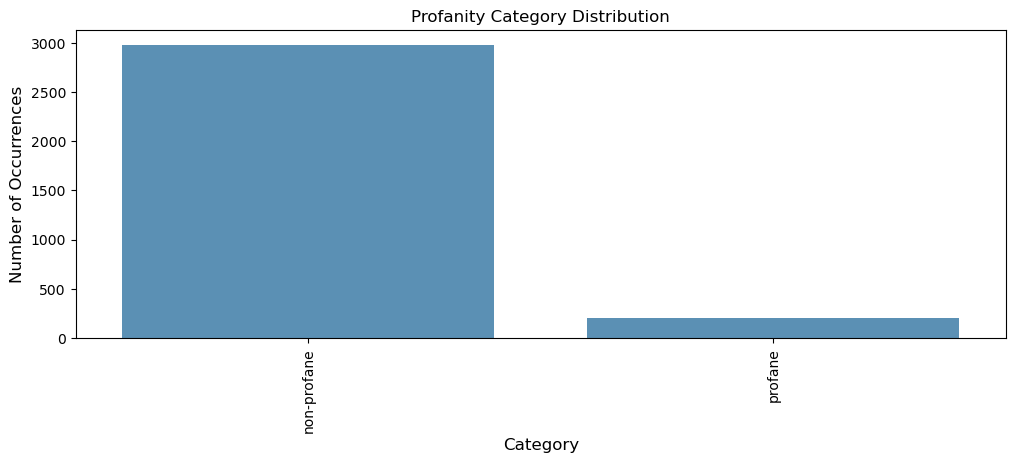

In [11]:
# Count occurrences of each category (profane vs. non-profane)
cnt_pro = df['Label'].value_counts()

# Create bar plot
plt.figure(figsize=(12, 4))
sns.barplot(x=cnt_pro.index, y=cnt_pro.values, alpha=0.8)

# Labels and formatting
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=90)
plt.title("Profanity Category Distribution")

# Show plot
plt.show()

In [12]:
def print_message(index):
    example = df[df.index == index][['text', 'Label']].values[0]
    if len(example) > 0:
        print('Text:', example[0])
        print('Label:', example[1])

# Example usage
print_message(12)
print_message(653)

Text: sure it is january 15 1985
Label: non-profane
Text: thank you mark i appreciate your understanding
Label: non-profane


## Handling Class Imbalance

In [142]:
from imblearn.over_sampling import SMOTE

# Convert labels to numeric format
df['Label'] = df['Label'].map({'non-profane': 0, 'profane': 1})

# Separate features and labels
X_resampled, y_resampled = SMOTE().fit_resample(X, df['Label'])

# Confirm new class distribution
print(pd.Series(y_resampled).value_counts())


Label
0    2981
1    2981
Name: count, dtype: int64


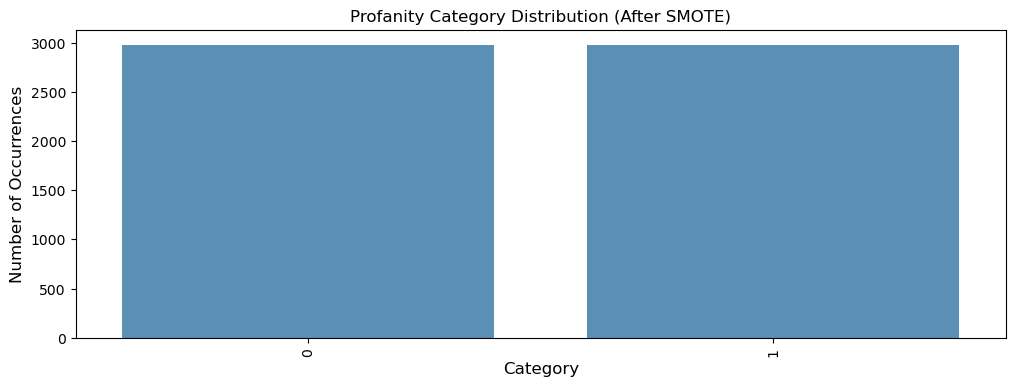

In [148]:
# Count occurrences of each category in the resampled dataset
cnt_pro_resampled = pd.Series(y_resampled).value_counts()

# Create bar plot for resampled data
plt.figure(figsize=(12, 4))
sns.barplot(x=cnt_pro_resampled.index, y=cnt_pro_resampled.values, alpha=0.8)

# Labels and formatting
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Category', fontsize=12)
plt.xticks(rotation=90)
plt.title("Profanity Category Distribution (After SMOTE)")

# Show plot
plt.show()


## Text Preprocessing

In [149]:
from bs4 import BeautifulSoup
import re
import nlpaug.augmenter.word as naw

In [150]:
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = re.sub(r'http\S+', r'<URL>', text)
    text = text.lower()
    text = text.replace('x', '')
    return text

# Apply text cleaning
df['text'] = df['text'].apply(cleanText)

In [15]:
# Train-test split
train, test = train_test_split(df, test_size=0.000001, random_state=42)

In [16]:
# Tokenization function
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) <= 0:
                continue
            tokens.append(word.lower())
    return tokens


In [151]:
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from gensim.models.doc2vec import TaggedDocument

# Alternative tokenizer using regex
def tokenize_text(text):
    return re.findall(r'\b\w+\b', text.lower())  # Extracts words from text

# Apply tokenization
train_tagged = train.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r['Label']]), axis=1
)
test_tagged = test.apply(
    lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r['Label']]), axis=1
)

# Define max features and max sequence length
max_features = 500000
MAX_SEQUENCE_LENGTH = 50

# Tokenizer to process text
tokenizer = Tokenizer(num_words=max_features, split=' ', filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['text'].values)

# Convert texts to sequences and pad them
X = tokenizer.texts_to_sequences(df['text'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

print('Shape of data tensor:', X.shape)


Shape of data tensor: (3187, 50)


In [18]:
import time
from gensim.models import Doc2Vec
import numpy as np
from tqdm import tqdm
from sklearn import utils

# Initialize the model
d2v_model = Doc2Vec(dm=1, dm_mean=1, vector_size=20, window=8, min_count=1, workers=1, alpha=0.065, min_alpha=0.065)
d2v_model.build_vocab([x for x in tqdm(train_tagged.values)])

# Start measuring time
start_time = time.time()

# Training loop
for epoch in range(30):
    d2v_model.train(utils.shuffle([x for x in tqdm(train_tagged.values)]), total_examples=len(train_tagged.values), epochs=1)
    d2v_model.alpha -= 0.002
    d2v_model.min_alpha = d2v_model.alpha

# End measuring time
end_time = time.time()
print(f"Training time: {end_time - start_time} seconds")

# Create the embedding matrix
embedding_matrix = np.zeros((len(d2v_model.dv.key_to_index) + 1, 20))

for i, vec in enumerate(d2v_model.dv.vectors):
    embedding_matrix[i] = vec

print(embedding_matrix.shape)


100%|██████████| 3186/3186 [00:00<00:00, 10017280.77it/s]


Training time: 1.5000219345092773 seconds
(3, 20)


## Measuring distance between two vectors (related to cosine similarity)

In [152]:
# Finding the most similar words to the word 'verify'
similar_words_verify = d2v_model.wv.most_similar(positive=['verify'], topn=10)
print(similar_words_verify)

# Finding the most similar words to the word 'information'
similar_words_information = d2v_model.wv.most_similar(positive=['information'], topn=10)
print(similar_words_information)

[('confirm', 0.8177965879440308), ('provide', 0.7700503468513489), ('committing', 0.6843839883804321), ('national', 0.6782755255699158), ('protect', 0.6160517334938049), ('city', 0.6069803833961487), ('overdue', 0.5995833277702332), ('co', 0.5920254588127136), ('yz', 0.5886183977127075), ('give', 0.5796219706535339)]
[('identity', 0.803688645362854), ('details', 0.6126253604888916), ('corp', 0.5680633783340454), ('see', 0.5574718713760376), ('also', 0.553905189037323), ('address', 0.5258530974388123), ('had', 0.5243110656738281), ('feel', 0.5177683234214783), ('suits', 0.5089391469955444), ('balance', 0.5078727006912231)]


## Create the LSTM Model

In [153]:
print("Embedding matrix shape:", embedding_matrix.shape)


Embedding matrix shape: (1151, 20)


In [154]:
vocab_size = len(d2v_model.wv.key_to_index) + 1  # Number of unique words + 1
embedding_dim = 20  # Embedding dimensions
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, idx in d2v_model.wv.key_to_index.items():
    if idx < vocab_size:  # Ensure index is within bounds
        embedding_matrix[idx] = d2v_model.wv[word]

print("Rebuilt embedding matrix shape:", embedding_matrix.shape)


Rebuilt embedding matrix shape: (1151, 20)


In [157]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Embedding. Dropout
from keras.utils import plot_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

SyntaxError: invalid syntax (2871689188.py, line 2)

In [159]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.layers import Dropout
import tensorflow as tf

# Initialize the model
model = Sequential()

# Embedding layer
model.add(
    Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        input_length=X.shape[1],
        weights=[embedding_matrix],
        trainable=True
    )
)

# LSTM layer
model.add(LSTM(50, return_sequences=False))

model.add(Dropout(0.3)) 

# Output layer with softmax activation
model.add(Dense(2, activation="softmax"))

# Force model building
model.build(input_shape=(None, X.shape[1]))

# Model summary
model.summary()

# Compile the model
model.compile(
    optimizer="adam", 
    loss="binary_crossentropy", 
    metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC()]
)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 50, 20)         │        23,020 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 50)             │        14,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │           102 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 37,322 (145.79 KB)

 Trainable params: 37,322 (145.79 KB)

 Non-trainable params: 0 (0.00 B)

In [160]:
from keras.utils import plot_model
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd

In [161]:
print(df.columns)


Index(['text', 'Label'], dtype='object')


In [162]:
# One-hot encode the 'Label' column
Y = pd.get_dummies(df['Label']).values

# Train-test split
# from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, stratify=df['Label'], random_state=42)


print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(2708, 50) (2708, 2)
(279, 50) (279, 2)


In [163]:
print("Max value in X_train:", X_train.max())
print("Max value in X_test:", X_test.max())
print("Vocab size:", vocab_size)

Max value in X_train: 1150
Max value in X_test: 1134
Vocab size: 1151


In [164]:
# Replace values in X_train and X_test that exceed the vocab size
X_train = np.where(X_train >= vocab_size, 0, X_train)
X_test = np.where(X_test >= vocab_size, 0, X_test)

# Check the maximum values again
print("Max value in X_train after fix:", X_train.max())
print("Max value in X_test after fix:", X_test.max())


# Re-train the model
batch_size = 32
history = model.fit(
    X_train, Y_train,
    validation_data=(X_test, Y_test),  
    epochs=250,
    batch_size=batch_size,
    verbose=2
)

Max value in X_train after fix: 1150
Max value in X_test after fix: 1134
Epoch 1/250
85/85 - 2s - 21ms/step - accuracy: 0.9298 - auc_10: 0.9377 - loss: 0.2880 - precision_10: 0.9298 - recall_10: 0.9298 - val_accuracy: 0.9391 - val_auc_10: 0.9809 - val_loss: 0.2076 - val_precision_10: 0.9391 - val_recall_10: 0.9391
Epoch 2/250
85/85 - 1s - 7ms/step - accuracy: 0.9346 - auc_10: 0.9738 - loss: 0.1956 - precision_10: 0.9346 - recall_10: 0.9346 - val_accuracy: 0.9355 - val_auc_10: 0.9822 - val_loss: 0.1466 - val_precision_10: 0.9355 - val_recall_10: 0.9355
Epoch 3/250
85/85 - 1s - 7ms/step - accuracy: 0.9538 - auc_10: 0.9880 - loss: 0.1238 - precision_10: 0.9538 - recall_10: 0.9538 - val_accuracy: 0.9570 - val_auc_10: 0.9940 - val_loss: 0.1027 - val_precision_10: 0.9570 - val_recall_10: 0.9570
Epoch 4/250
85/85 - 1s - 7ms/step - accuracy: 0.9660 - auc_10: 0.9928 - loss: 0.0905 - precision_10: 0.9660 - recall_10: 0.9660 - val_accuracy: 0.9642 - val_auc_10: 0.9955 - val_loss: 0.0890 - val_pre

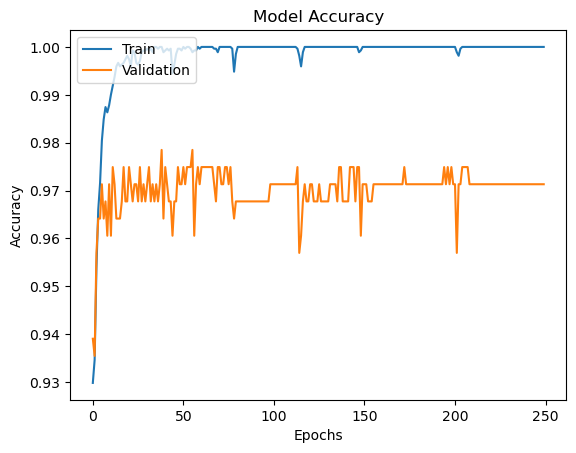

In [165]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()

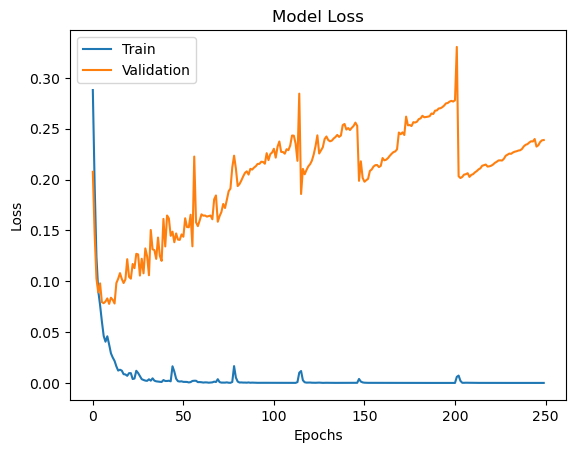

In [166]:
# Plot loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(loc='upper left')
plt.show()

In [167]:
# Evaluate the model
train_loss, train_acc, train_precision, train_recall, train_auc = model.evaluate(X_train, Y_train, verbose=2)
test_loss, test_acc, test_precision, test_recall, test_auc= model.evaluate(X_test, Y_test, verbose=2)

# Print the results
print(f'Train Accuracy: {train_acc:.3f}, Test Accuracy: {test_acc:.4f}')
print(f'Train Precision: {train_precision:.3f}, Test Precision: {test_precision:.3f}')
print(f'Train Recall: {train_recall:.3f}, Test Recall: {test_recall:.3f}')
print(f'Train AUC: {train_auc:.3f}, Test AUC: {test_auc:.3f}')

85/85 - 0s - 2ms/step - accuracy: 1.0000 - auc_10: 1.0000 - loss: 2.3599e-06 - precision_10: 1.0000 - recall_10: 1.0000
9/9 - 0s - 3ms/step - accuracy: 0.9713 - auc_10: 0.9746 - loss: 0.2389 - precision_10: 0.9713 - recall_10: 0.9713
Train Accuracy: 1.000, Test Accuracy: 0.9713
Train Precision: 1.000, Test Precision: 0.971
Train Recall: 1.000, Test Recall: 0.971
Train AUC: 1.000, Test AUC: 0.975


In [168]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

# Predict probabilities for the test set
yhat_probs = model.predict(X_test, verbose=0)
print("Predicted probabilities:", yhat_probs)

# Predict crisp classes (binary or multi-class) for the test set
yhat_classes = (yhat_probs > 0.5).astype(int)  # Convert probabilities to binary predictions
print("Predicted classes:", yhat_classes)

# Round labels for evaluation (in case of multi-class or multi-label)
rounded_labels = np.argmax(Y_test, axis=1)  # Assuming Y_test is one-hot encoded
print("Rounded true labels:", rounded_labels)


Predicted probabilities: [[1.00000000e+00 1.33662752e-15]
 [1.04854439e-12 1.00000000e+00]
 [1.00000000e+00 6.06904175e-13]
 [1.00000000e+00 1.63208770e-16]
 [1.00000000e+00 2.19597738e-18]
 [1.00000000e+00 4.70804801e-17]
 [1.00000000e+00 1.80705860e-17]
 [1.00000000e+00 9.00647803e-16]
 [1.00000000e+00 1.50511487e-14]
 [1.00000000e+00 7.53033069e-17]
 [1.00000000e+00 8.70790121e-14]
 [1.00000000e+00 1.04656479e-15]
 [1.00000000e+00 4.17116531e-16]
 [1.00000000e+00 7.03563671e-16]
 [2.71116718e-15 1.00000000e+00]
 [1.00000000e+00 1.35793463e-16]
 [1.00000000e+00 8.04031520e-16]
 [1.00000000e+00 6.09891929e-18]
 [1.00000000e+00 8.83459798e-17]
 [1.00000000e+00 5.10161868e-09]
 [1.00000000e+00 3.07685645e-16]
 [1.00000000e+00 4.38475446e-16]
 [1.00000000e+00 8.66689472e-17]
 [1.00000000e+00 5.91234079e-16]
 [1.00000000e+00 9.04689884e-17]
 [1.00000000e+00 3.31182722e-19]
 [1.00000000e+00 4.32171161e-19]
 [1.00000000e+00 1.66487180e-12]
 [1.00000000e+00 6.57499669e-15]
 [1.00000000e+00 4

Confusion Matrix:
 [[271   8]
 [  8 271]]


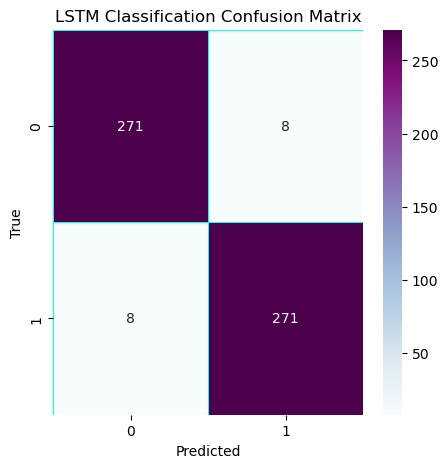

In [169]:
# For binary classification, the predicted classes will be 0 or 1
yhat_classes = (yhat_probs > 0.5).astype(int).flatten()  # Flatten to 1D

# Ensure Y_test is also 1D (binary)
rounded_labels = Y_test.flatten()

# Confusion Matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


Confusion Matrix:
 [[257   5]
 [  3  14]]


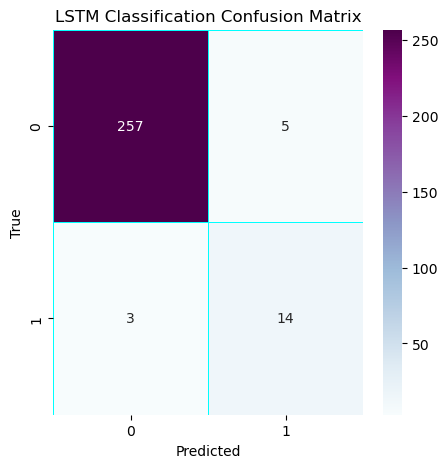

In [170]:
# For multi-class classification, convert the predicted probabilities to class indices
yhat_classes = np.argmax(yhat_probs, axis=1)

# If Y_test is one-hot encoded, convert it to class indices
rounded_labels = np.argmax(Y_test, axis=1)

# Confusion Matrix
cm = confusion_matrix(rounded_labels, yhat_classes)
print("Confusion Matrix:\n", cm)

# Plot confusion matrix
f, ax = plt.subplots(figsize=(5, 5))
sns.heatmap(cm, annot=True, linewidth=0.7, linecolor='cyan', fmt='g', ax=ax, cmap="BuPu")
plt.title('LSTM Classification Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [171]:
# Evaluate the model on the remaining test set
results = model.evaluate(X_test, Y_test, verbose=1, batch_size=batch_size)

# Print all evaluation metrics
print(f"Score (loss): {results[0]:.2f}")  # Loss
print(f"Accuracy: {results[1]:.2f}")  # Accuracy
print(f"Precision: {results[2]:.2f}")  # Precision
print(f"Recall: {results[3]:.2f}")  # Recall
print(f"AUC: {results[4]:.2f}")  # AUC


9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9788 - auc_10: 0.9798 - loss: 0.2386 - precision_10: 0.9788 - recall_10: 0.9788     
Score (loss): 0.24
Accuracy: 0.97
Precision: 0.97
Recall: 0.97
AUC: 0.97


In [172]:
# Save the model after evaluation
model.save('profanity.keras')

## Test with new and different data set aside from the data to build the model.

In [173]:
# Tokenize and predict new messages
message = ['Your account has been flagged for suspicious activity. Please call us immediately to resolve the issue.']

# Tokenizing and padding the message
seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=X.shape[1], dtype='int32', value=0)

# Making prediction with the model
pred = model.predict(padded)

# Labels for classification: 0 = not profane, 1 = profane
labels = ['not profane', 'profane']

# Getting the index of the class with the highest probability
predicted_class = np.argmax(pred)

# Showing the predicted class with its probability
print(f"Prediction: {labels[predicted_class]} with probability: {pred[0][predicted_class]*100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Prediction: not profane with probability: 100.00%
